In [1]:
!pip install -q tiktoken datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import math
import pytz
from datetime import datetime
import tiktoken
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.optim import AdamW
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
from torch.utils.data import IterableDataset, DataLoader
from datasets import load_dataset, load_from_disk
from typing import Optional

In [3]:
class Config:
    def __init__(self):
        enc = tiktoken.get_encoding("gpt2")

        self.tokenizer                  = enc
        self.eot_token                  = enc.eot_token
        self.pad_token                  = enc.n_vocab
        self.vocab_size                 = enc.n_vocab + 1
        self.min_sequence_length        = 128
        self.dimension                  = 512
        self.block_size                 = 512
        self.block_stride               = 512
        self.max_blocks_per_example     = 4
        self.num_layers                 = 16
        self.num_heads                  = 8
        self.dropout_attention          = 0.0
        self.dropout_multihead          = 0.01 #0.05 #0.01 #0.1 # changed for epoch 3
        self.dropout_ff_fc              = 0.0
        self.dropout_ff_proj            = 0.01 #0.05
        self.device                     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lr                         = 1e-4 #0.0003 #1e-4 #0.000135 #0.00015 #0.0002 #0.0003
        self.lr_min                     = 3e-5 #1e-6 #0.00003 #1e-6 #2e-6 #0.00001
        self.lr_warmup_steps            = 20000 #2000 #20000 #1000 #500
        self.grad_norm_clip_value       = 1.5 #1.0 #0.3 #0.4
        self.optimizer_betas            = (0.9, 0.999) #(0.9, 0.95)
        self.optimizer_eps              = 1e-8
        self.optimizer_weight_decay     = 0.01 #0.02 #0.01 #0.1 # changed for epoch 3
        self.batch_size                 = 32
        self.max_epochs                 = 5
        self.total_steps                = 100000 #253911 #438_750 #453_125 #618_125  # NOTE: 255911 is a per-epoch number; for cosine decay.
        self.train_print_interval       = 100
        self.train_print_ema_beta       = 0.995 #0.998 #0.995 #0.998 #0.98 #0.95
        self.checkpoint_directory       = "/content/drive/My Drive/" #"/home/sagemaker-user/"
        self.checkpoint_interval        = 5000
        self.checkpoint_copy_interval   = 10000
        self.validation_interval        = 100
        self.validation_max_steps       = 2

    def __repr__(self):
        return "Configuration values:\n" + \
            "\n".join([f"  {p.__repr__()}: {getattr(self, p)}" for p in dir(self) if not p.startswith("__") and not p.startswith("_")])


def init_model(config):
    torch.manual_seed(99)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(99)
    torch.set_float32_matmul_precision('high')
    model = Model(config)
    #model = torch.compile(model)
    return model.to(config.device)


def init_weights(model):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)


class AttentionHead(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        head_dimension  = config.dimension // config.num_heads

        self.query        = nn.Linear(config.dimension, head_dimension)
        self.key          = nn.Linear(config.dimension, head_dimension, bias=False)
        self.value        = nn.Linear(config.dimension, head_dimension)
        self.scale        = 1.0 / (head_dimension ** 0.5)
        self.attn_dropout = nn.Dropout(config.dropout_attention)
        self.register_buffer('tril', torch.tril(torch.ones(config.block_size, config.block_size, device=config.device)))

    def forward(self, x, padding_mask: Optional[Tensor] = None):
        B, T, C = x.shape
        assert T <= self.config.block_size, f"Input sequence length {T} exceeds block size {self.config.block_size}."

        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        if padding_mask is not None:
            padding_mask = padding_mask[:, None, :T].bool().expand(B, T, T)

        causal_mask = self.tril[:T, :T].bool()[None, :, :]

        if padding_mask is not None:
            combined_mask = causal_mask & padding_mask
        else:
            combined_mask = causal_mask

        attention_scores  = (Q @ K.transpose(-2, -1)) * self.scale
        attention_scores  = attention_scores.masked_fill(~combined_mask, float('-inf'))
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.attn_dropout(attention_weights)
        output = attention_weights @ V

        return output


class MultiHeadAttention(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.dimension % config.num_heads == 0, f"Embedding dimension {config.dimension} is not divisible by number of heads {config.num_heads}."

        self.heads    = nn.ModuleList([AttentionHead(config) for _ in range(config.num_heads)])
        self.proj     = nn.Linear(config.dimension, config.dimension)
        self.dropout  = nn.Dropout(config.dropout_multihead)

    def forward(self, x, padding_mask: Optional[Tensor] = None):
        head_outputs  = [head(x, padding_mask) for head in self.heads]
        output        = torch.cat(head_outputs, dim=-1)
        output        = self.proj(output)
        return self.dropout(output)


class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.dimension, 4 * config.dimension),
            nn.GELU(),
            nn.Dropout(config.dropout_ff_fc),
            nn.Linear(4 * config.dimension, config.dimension),
            nn.Dropout(config.dropout_ff_proj)
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1  = nn.LayerNorm(config.dimension)
        self.attn = MultiHeadAttention(config)
        self.ln2  = nn.LayerNorm(config.dimension)
        self.ff   = FeedForward(config)

    def forward(self, x, padding_mask):
        x = x + self.attn(self.ln1(x), padding_mask)
        return x + self.ff(self.ln2(x))


class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config             = config
        self.token_embedding    = nn.Embedding(config.vocab_size, config.dimension, padding_idx=config.pad_token)
        self.position_embedding = nn.Embedding(config.block_size, config.dimension)
        self.blocks             = nn.ModuleList([Block(config) for _ in range(config.num_layers)])
        self.ln_f               = nn.LayerNorm(config.dimension)
        self.lm_head            = nn.Linear(config.dimension, config.vocab_size)

    def forward(self, idx, targets=None, padding_mask: Optional[Tensor] = None):
        _, T = idx.shape
        assert T <= self.config.block_size, f"Input sequence length {T} exceeds block size {self.config.block_size}."

        token_emb = self.token_embedding(idx)
        pos       = torch.arange(T, device=self.config.device)
        pos_emb   = self.position_embedding(pos).unsqueeze(0)
        x         = token_emb + pos_emb

        for block in self.blocks:
            x = block(x, padding_mask)

        x         = self.ln_f(x)
        logits    = self.lm_head(x)

        loss = None
        if targets is not None:
            logits  = logits.view(-1, logits.size(-1))
            targets = targets.view(-1)
            loss    = F.cross_entropy(logits, targets, ignore_index=self.config.pad_token)

        return logits, loss

    def generate(self, input_ids, max_new_tokens, temperature=0.7, top_p=0.9, top_k=50):
        if temperature < 0:
            raise ValueError(f"`temperature` must be ≥ 0, got {temperature}")
        if max_new_tokens < 1:
            raise ValueError(f"`max_new_tokens` must be ≥ 1, got {max_new_tokens}")

        input_ids     = input_ids.to(self.config.device)
        input_ids     = input_ids.unsqueeze(0) if input_ids.dim() == 1 else input_ids
        was_training  = self.training
        self.eval()

        with torch.no_grad():
            for _ in range(max_new_tokens):
                input_ids   = input_ids[:, -self.config.block_size:]
                logits, _   = self(input_ids)
                logits      = logits[:, -1, :]

                if temperature == 0:
                    next_token  = torch.argmax(logits, dim=-1, keepdim=True)
                else:
                    logits      = logits / temperature
                    if top_k is not None and top_k < logits.size(-1):
                        logits  = self.top_k_filter(logits, top_k=top_k)
                    logits      = self.top_p_filter(logits, top_p=top_p)
                    probs       = F.softmax(logits, dim=-1)
                    next_token  = torch.multinomial(probs, num_samples=1)

                # TODO - review. this might break when the input is a batch
                if next_token.item() == self.config.eot_token:
                    break

                input_ids = torch.cat((input_ids, next_token), dim=1)

        if was_training:
            self.train()

        return input_ids

    def top_k_filter(self, logits, top_k, filter_value=-float("Inf")):
        topk_logits, topk_indices = torch.topk(logits, top_k, dim=-1)
        mask = logits < topk_logits[..., -1, None]
        return logits.masked_fill(mask, filter_value)

    def top_p_filter(self, logits, top_p=0.9, filter_value=-float('Inf')):
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        probs = F.softmax(sorted_logits, dim=-1)
        cumulative_probs = torch.cumsum(probs, dim=-1)
        mask = cumulative_probs > top_p
        mask[..., 1:] = mask[..., :-1].clone()
        mask[..., 0] = False
        mask = mask.scatter(dim=-1, index=sorted_indices, src=mask)
        return logits.masked_fill(mask, filter_value)


def collate(batch, config):
    prompts    = [f"Question: {ex['question']}\nAnswer: " for ex in batch]
    answers    = [ex["answer"] for ex in batch]

    prompt_ids = [config.tokenizer.encode(p) for p in prompts]
    answer_ids = [config.tokenizer.encode(a) + [config.eot_token] for a in answers]

    input_seqs, label_seqs = [], []
    for p_ids, a_ids in zip(prompt_ids, answer_ids):
        seq       = p_ids + a_ids
        input_seq = seq[:-1]
        label_seq = seq[1:]
        input_seqs.append(input_seq)
        label_seqs.append(label_seq)

    max_len = max(len(s) for s in input_seqs)
    x, mask, y = [], [], []
    for inp, lab in zip(input_seqs, label_seqs):
        pad_len = max_len - len(inp)
        x.append(inp + [config.pad_token] * pad_len)
        mask.append([1] * len(inp) + [0] * pad_len)
        y.append(lab + [config.pad_token] * pad_len)

    return {
        "x":             torch.tensor(x,    dtype=torch.long),
        "padding_mask":  torch.tensor(mask, dtype=torch.long),
        "y":             torch.tensor(y,    dtype=torch.long),
    }


class StreamedDataset(IterableDataset):
    def __init__(self, config, dataset, position=0):
        self.config   = config
        self.dataset  = dataset
        self.position = position
        if position > 0:
            self.dataset = dataset.skip(position)
            print(f"Skipped {position} examples already seen this epoch.")

    def __iter__(self):
        for example in self.dataset:
            self.position += 1
            question = example["question"]
            answer   = example["answer"]
            yield {"question": question, "answer": answer}


class Trainer():
    def __init__(self, config):
        self.config = config
        persistent_checkpoints_directory = self.config.checkpoint_directory + "checkpoints"
        os.makedirs(persistent_checkpoints_directory, exist_ok=True)

    def init_optimizer(self, model):
        return AdamW(model.parameters(),
                     lr = self.config.lr,
                     betas = self.config.optimizer_betas,
                     eps = self.config.optimizer_eps,
                     weight_decay = self.config.optimizer_weight_decay)

    def init_scheduler(self, optimizer, last_step=-1):
        cosine_scheduler  = CosineAnnealingLR(optimizer,
                                              T_max=self.config.total_steps,
                                              eta_min=self.config.lr_min,
                                              last_epoch=last_step)

        return cosine_scheduler

    def init_dataset(self, dataset_position):
        dataset_train           = load_dataset("LLukas22/nq-simplified", split="train", streaming=True)
        dataset_train           = dataset_train.map(lambda x: {"answer": x["answers"]["text"][0]})
        dataset_val             = load_dataset("LLukas22/nq-simplified", split="test", streaming=True)
        dataset_val             = dataset_val.map(lambda x: {"answer": x["answers"]["text"][0]})
        streamed_dataset_train  = StreamedDataset(self.config, dataset_train, position=dataset_position)
        streamed_dataset_val    = StreamedDataset(self.config, dataset_val, 0)
        return streamed_dataset_train, streamed_dataset_val

    def train(self, model):
        optimizer           = self.init_optimizer(model)
        scheduler           = self.init_scheduler(optimizer)
        losses, grad_norms  = self.load_train_metrics()
        last_epoch, last_step, loss_ema, dataset_position = self.load_checkpoint(model, optimizer, scheduler)

        start_epoch = last_epoch
        start_step  = last_step + 1

        # NOTE - This is a temporary hack.
        #        Remember to comment it out before the next resume!
        start_epoch       = 4
        start_step        = 0
        dataset_position  = 0

        # NOTE - This is a temporary hack.
        #        Remember to comment it out before the next resume!
        #for pg in optimizer.param_groups:
        #    pg['lr'] = 0.000047 #self.config.lr
        #    #pg['weight_decay'] = self.config.optimizer_weight_decay
        #scheduler = self.init_scheduler(optimizer)

        model.train()

        try:
            for epoch in range(start_epoch, self.config.max_epochs):
                if epoch > start_epoch:
                    start_step = 0
                    dataset_position = 0

                print(f'\nStarting epoch {epoch + 1} at step {start_step + 1}.')

                streamed_dataset_train, streamed_dataset_val  = self.init_dataset(dataset_position)
                dataloader_train  = DataLoader(streamed_dataset_train, batch_size=self.config.batch_size, collate_fn=lambda x: collate(x, self.config))
                dataloader_val    = None if streamed_dataset_val is None else DataLoader(streamed_dataset_val, batch_size=self.config.batch_size, collate_fn=lambda x: collate(x, self.config))

                for step, batch in enumerate(dataloader_train, start=start_step):
                    xb = batch["x"].to(self.config.device)
                    yb = batch["y"].to(self.config.device)
                    padding_mask = batch["padding_mask"].to(self.config.device)

                    _, loss = model(xb, yb, padding_mask)
                    optimizer.zero_grad(set_to_none=True)
                    loss.backward()
                    norm = nn.utils.clip_grad_norm_(model.parameters(), self.config.grad_norm_clip_value)
                    optimizer.step()
                    scheduler.step()
                    losses.append(loss.item())
                    grad_norms.append(norm.item())

                    if loss_ema is None:
                        loss_ema = loss.item()
                    else:
                        loss_ema = loss_ema * self.config.train_print_ema_beta + (1 - self.config.train_print_ema_beta) * loss.item()

                    now = datetime.now(pytz.timezone('America/New_York')).strftime('%m %d %I:%M %p')

                    if (step + 1) % self.config.checkpoint_interval == 0:
                        self.save_checkpoint(model, optimizer, scheduler, epoch, step, loss_ema, streamed_dataset_train.position)
                        self.save_train_metrics(losses, grad_norms)

                    if (step + 1) % self.config.checkpoint_copy_interval == 0:
                        self.save_checkpoint(model, optimizer, scheduler, epoch, step, loss_ema, streamed_dataset_train.position, file_name=f"checkpoints/checkpoint-{now}.pt")
                        self.save_train_metrics(losses, grad_norms, file_name=f"checkpoints/train-metrics-{now}.pt")

                    if step == 0 or (step + 1) % self.config.train_print_interval == 0:
                        lr = optimizer.param_groups[0]['lr']
                        print(f"{now} | Epoch: {epoch + 1} | Step: {step + 1} | Train Loss EMA: {loss.item():.2f} | LR: {lr:.6f} | Grad Norm: {norm:.2f}")

                    if dataloader_val is not None:
                        if (step + 1) % self.config.validation_interval == 0:
                            self.validate(model, dataloader_val, step)
                            model.train()

                self.save_checkpoint(model, optimizer, scheduler, epoch, step, loss_ema, streamed_dataset_train.position, file_name=f"checkpoints/checkpoint-epoch-{epoch + 1}-final.pt")
                self.save_train_metrics(losses, grad_norms, file_name=f"checkpoints/train-metrics-epoch-{epoch + 1}-final.pt")
                print(f"Epoch {epoch + 1} completed.")
        except KeyboardInterrupt:
            if 'streamed_dataset_train' in locals():
                dataset_position = streamed_dataset_train.position
            self.save_checkpoint(model, optimizer, scheduler, epoch, step, loss_ema, dataset_position, 'checkpoint-interruptted.pt')
            self.save_train_metrics(losses, grad_norms, 'train-metrics-interruptted.pt')
            print("Training interrupted. Model saved.")

    def validate(self, model, dataloader_val, train_step):
        total_val_loss  = 0.0
        num_val_steps   = 0
        val_losses = self.load_val_metrics()

        model.eval()

        with torch.no_grad():
            for step, batch in enumerate(dataloader_val):
                if step >= self.config.validation_max_steps:
                    break

                xb            = batch["x"].to(self.config.device)
                yb            = batch["y"].to(self.config.device)
                padding_mask  = batch["padding_mask"].to(self.config.device)

                _, loss_eval    = model(xb, yb, padding_mask)
                total_val_loss  = total_val_loss + loss_eval.item()
                num_val_steps   = num_val_steps + 1

        avg_val_loss = total_val_loss / max(1, num_val_steps)
        val_losses.append(avg_val_loss)
        self.save_val_metrics(val_losses)

        if train_step == 0 or (train_step + 1) % self.config.train_print_interval == 0:
            print(f"    Validation Loss: {avg_val_loss:.2f}")

    def save_checkpoint(self, model, optimizer, scheduler, epoch, step, loss_ema, dataset_position, file_name="checkpoint.pt"):
        checkpoint_path = f'{self.config.checkpoint_directory}{file_name}'
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch': epoch,
            'step': step,
            "loss_ema": loss_ema,
            'dataset_position': dataset_position
        }
        torch.save(checkpoint, checkpoint_path)

    def load_checkpoint(self, model, optimizer, scheduler=None, file_name="checkpoint.pt"):
        checkpoint_path = f'{self.config.checkpoint_directory}{file_name}'

        if not os.path.exists(checkpoint_path):
            print(f"Checkpoint file not found at {checkpoint_path}")
            return 0, -1, None, 0

        print(f"Trying to load checkpoint from file {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=self.config.device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler is not None:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        epoch             = checkpoint['epoch']
        step              = checkpoint['step']
        loss_ema          = checkpoint.get('loss_ema', None) or checkpoint.get('ema_loss', None)  # fix this at some point
        dataset_position  = checkpoint['dataset_position']

        print(f"Checkpoint loaded: Epoch {epoch + 1}, Step {step + 1}, Train Loss EMA {loss_ema:.2f}, Dataset Position {dataset_position}")

        return epoch, step, loss_ema, dataset_position

    def save_train_metrics(self, train_losses, grad_norms, file_name="train-metrics.pt"):
        metrics_path = f'{self.config.checkpoint_directory}{file_name}'
        metrics = {
            'train_losses': train_losses,
            'grad_norms': grad_norms
        }
        torch.save(metrics, metrics_path)

    def load_train_metrics(self, file_name="train-metrics.pt"):
        metrics_path = f'{self.config.checkpoint_directory}{file_name}'

        if not os.path.exists(metrics_path):
            return [], []

        metrics       = torch.load(metrics_path, map_location=self.config.device)
        train_losses  = metrics.get("train_losses")
        grad_norms    = metrics.get("grad_norms")
        return train_losses, grad_norms

    def save_val_metrics(self, val_losses):
        metrics_path = f'{self.config.checkpoint_directory}val-metrics.pt'
        metrics = {
            'val_losses': val_losses
        }
        torch.save(metrics, metrics_path)

    def load_val_metrics(self):
        metrics_path = f'{self.config.checkpoint_directory}val-metrics.pt'

        if not os.path.exists(metrics_path):
            return []

        metrics = torch.load(metrics_path, map_location=self.config.device)
        val_losses = metrics.get("val_losses")
        return val_losses


class Tester():
    def __init__(self, config):
        self.config = config

    def load_parameters(self, model, file_name="checkpoint.pt"):
        checkpoint_path = f'{self.config.checkpoint_directory}{file_name}'

        if not os.path.exists(checkpoint_path):
            print(f"Checkpoint file not found at {checkpoint_path}")
            return

        checkpoint = torch.load(checkpoint_path, map_location=self.config.device)
        model.load_state_dict(checkpoint['model_state_dict'])

        epoch             = checkpoint['epoch']
        step              = checkpoint['step']
        loss_ema          = checkpoint.get('loss_ema', None) or checkpoint.get('ema_loss', None)
        dataset_position  = checkpoint['dataset_position']

        print(f"Checkpoint loaded: Epoch {epoch + 1}, Step {step + 1}, Train Loss EMA {loss_ema:.2f}, Dataset Position {dataset_position}")

    def test(self, model):
        dataset_test          = load_dataset("LLukas22/nq-simplified", split="test", streaming=True)
        dataset_test          = dataset_test.map(lambda x: {"answer": x["answers"]["text"][0]})
        streamed_dataset_test = StreamedDataset(self.config, dataset_test, position=0)
        dataloader_test       = DataLoader(streamed_dataset_test, batch_size=self.config.batch_size, collate_fn=lambda x: collate(x, self.config))
        test_losses = []

        model.eval()

        with torch.no_grad():
            for step, batch in enumerate(dataloader_test):
                xb = batch["x"].to(self.config.device)
                yb = batch["y"].to(self.config.device)
                padding_mask = batch["padding_mask"].to(self.config.device)

                _, loss_test = model(xb, yb, padding_mask)
                test_losses.append(loss_test.item())

        metrics_path = f'{self.config.checkpoint_directory}test-metrics.pt'
        metrics = {
            'test_losses': test_losses
        }
        torch.save(metrics, metrics_path)
        print('Test completed.')

    def do_smoke_test(self, model, temperature=0.7):
        prompts = [
            """What is Anarchism""",
            """What is the capital city of France""",
            """What is Paris""",
            """Where is The Great Wall of China located""",
            """Where is Mount Everest located""",
            """Who developed the theory of relativity""",
            """What did Albert Einstein develop""",
            """What is J.K. Rowling known for""",
            """Who was the first man to walk on the moon""",
            """What is python""",
            """Who was the 44th president of the United States""",
            """What does the human brain contain""",
            """Where was William Shakespeare born""",
            """When was William Shakespeare born""",
            """What is the chemical symbol for gold"""
        ]
        for prompt in prompts:
            prompt = f"Question: {prompt}\nAnswer: "
            x = torch.tensor(self.config.tokenizer.encode(prompt)).to(self.config.device)
            x = x.unsqueeze(0)
            y = model.generate(x, 20, temperature)
            y_decoded = self.config.tokenizer.decode(y[0].tolist())
            print()
            print("===Prompt is===")
            print(prompt)
            print("===Answer is===")
            print(y_decoded[len(prompt):])

    def to_ema(self, data, window_size=500):
        if len(data) == 0 or window_size <= 0:
            return data

        beta = 1 - 1 / window_size
        ema = [data[0]]

        for i in range(1, len(data)):
            ema.append(beta * ema[i-1] + (1 - beta) * data[i])

        return ema

    def plot_train_loss(self, train_losses):
        self._plot(train_losses, 'blue', 'Training Loss over Steps', 'Train Loss')

    def plot_train_grad_norm(self, grad_norms):
        self._plot(grad_norms, 'green', 'Training Grad Norm over Steps', 'Gradient Norm', 'Norm')

    def plot_val_loss(self, val_losses):
        self._plot(val_losses, 'orange', 'Validation Loss over Steps', 'Validation Loss')

    def plot_test_loss(self, test_losses):
        self._plot(test_losses, 'red', 'Test Loss over Steps', 'Test Loss')

    def _plot(self, data, color, title, label, ylabel="Loss"):
        num_steps = len(data)
        print("Number of steps:", num_steps)
        plt.figure(figsize=(10, 3))
        plt.plot(range(1, num_steps + 1), data, label=label, color=color)
        plt.xlabel('Step')
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [4]:
config = Config()
model = init_model(config)
num_params = sum(p.numel() for p in model.parameters())
print(config)
print(f"\nNumber of parameters: {num_params}")

Configuration values:
  'batch_size': 32
  'block_size': 512
  'block_stride': 512
  'checkpoint_copy_interval': 10000
  'checkpoint_directory': /content/drive/My Drive/
  'checkpoint_interval': 5000
  'device': cpu
  'dimension': 512
  'dropout_attention': 0.0
  'dropout_ff_fc': 0.0
  'dropout_ff_proj': 0.01
  'dropout_multihead': 0.01
  'eot_token': 50256
  'grad_norm_clip_value': 1.5
  'lr': 0.0001
  'lr_min': 3e-05
  'lr_warmup_steps': 20000
  'max_blocks_per_example': 4
  'max_epochs': 5
  'min_sequence_length': 128
  'num_heads': 8
  'num_layers': 16
  'optimizer_betas': (0.9, 0.999)
  'optimizer_eps': 1e-08
  'optimizer_weight_decay': 0.01
  'pad_token': 50257
  'tokenizer': <Encoding 'gpt2'>
  'total_steps': 100000
  'train_print_ema_beta': 0.995
  'train_print_interval': 100
  'validation_interval': 100
  'validation_max_steps': 2
  'vocab_size': 50258

Number of parameters: 102207570


In [ ]:
# cleanup
del model
del trainer
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
init_weights(model)

In [ ]:
trainer = Trainer(config)
trainer.train(model)

Trying to load checkpoint from file /content/drive/My Drive/checkpoint.pt
Checkpoint loaded: Epoch 4, Step 52573, Train Loss EMA 2.62, Dataset Position 1396380

Starting epoch 5 at step 1.


README.md:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

05 10 02:58 PM | Epoch: 5 | Step: 1 | Train Loss EMA: 6.46 | LR: 0.000046 | Grad Norm: 9.67
05 10 02:59 PM | Epoch: 5 | Step: 100 | Train Loss EMA: 2.93 | LR: 0.000046 | Grad Norm: 2.74
    Validation Loss: 3.02
05 10 02:59 PM | Epoch: 5 | Step: 200 | Train Loss EMA: 2.73 | LR: 0.000046 | Grad Norm: 2.50
    Validation Loss: 2.85
05 10 03:00 PM | Epoch: 5 | Step: 300 | Train Loss EMA: 2.52 | LR: 0.000046 | Grad Norm: 2.66
    Validation Loss: 2.81
05 10 03:00 PM | Epoch: 5 | Step: 400 | Train Loss EMA: 2.82 | LR: 0.000046 | Grad Norm: 2.58
    Validation Loss: 2.75
05 10 03:01 PM | Epoch: 5 | Step: 500 | Train Loss EMA: 2.55 | LR: 0.000046 | Grad Norm: 2.74
    Validation Loss: 2.71
05 10 03:01 PM | Epoch: 5 | Step: 600 | Train Loss EMA: 2.55 | LR: 0.000046 | Grad Norm: 2.71
    Validation Loss: 2.71
05 10 03:01 PM | Epoch: 5 | Step: 700 | Train Loss EMA: 2.84 | LR: 0.000046 | Grad Norm: 2.58
    Validation Loss: 2.66
05 10 03:02 PM | Epoch: 5 | Step: 800 | Train Loss EMA: 2.51 | LR: 0

Number of steps: 1212146


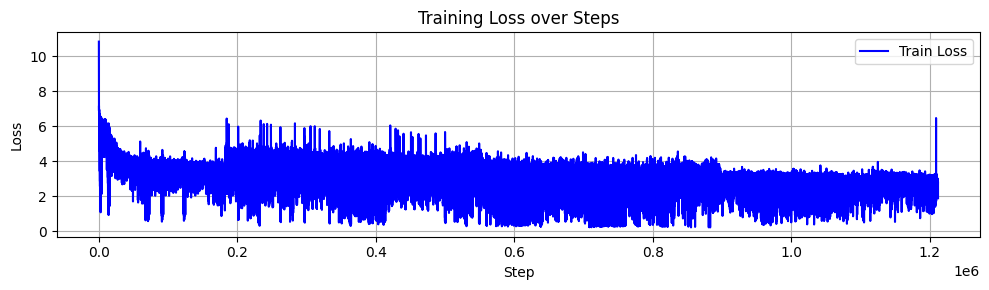

Number of steps: 1212146


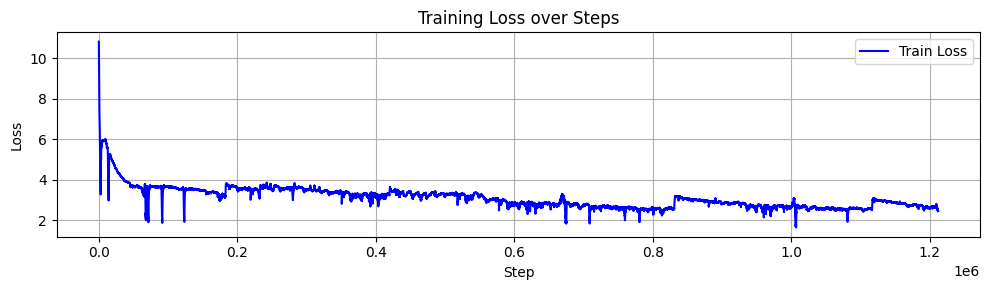

Number of steps: 1212146


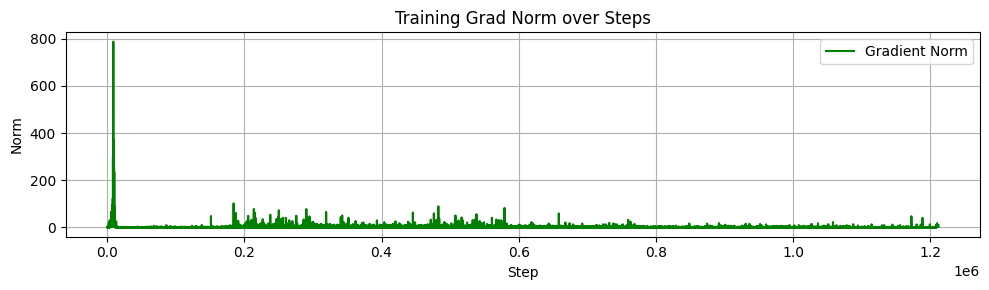

In [ ]:
trainer = Trainer(config)
tester = Tester(config)
t, g = trainer.load_train_metrics("checkpoints/FT-No-RAG/train-metrics-ft-epoch-5-final.pt")
t_ema = tester.to_ema(t)
#v = trainer.load_val_metrics()
tester.plot_train_loss(t)
tester.plot_train_loss(t_ema)
tester.plot_train_grad_norm(g)
#tester.plot_val_loss(v)
#tester.test(model, dataset_test)

In [5]:
tester = Tester(config)
#tester.load_parameters(model)
tester.load_parameters(model, file_name="checkpoints/FT-NoRAG/checkpoint-ft-epoch-5-final.pt")

Checkpoint loaded: Epoch 5, Step 2841, Train Loss EMA 2.42, Dataset Position 90882


In [14]:
tester = Tester(config)
tester.do_smoke_test(model, temperature=0.7)


===Prompt is===
Question: What is Anarchism
Answer: 
===Answer is===
the idea that people who are not the same in their own words can learn and behave differently

===Prompt is===
Question: What is the capital city of France
Answer: 
===Answer is===
Paris

===Prompt is===
Question: What is Paris
Answer: 
===Answer is===
a central park in Paris, France

===Prompt is===
Question: Where is The Great Wall of China located
Answer: 
===Answer is===
in the Hebei province of China

===Prompt is===
Question: Where is Mount Everest located
Answer: 
===Answer is===
in the Himalayas, on the Indian side of the Himalayas, between Nepal and Bh

===Prompt is===
Question: Who developed the theory of relativity
Answer: 
===Answer is===
Alfred Einstein

===Prompt is===
Question: What did Albert Einstein develop
Answer: 
===Answer is===
a method of theoretical physics

===Prompt is===
Question: What is J.K. Rowling known for
Answer: 
===Answer is===
"the world of the Harry Potter series and the books of 

In [13]:
#config = Config()
tester = Tester(config)
tester.do_smoke_test(model, temperature=0)


===Prompt is===
Question: What is Anarchism
Answer: 
===Answer is===
a social movement that aims to create a social and economic system that is based on the social and economic

===Prompt is===
Question: What is the capital city of France
Answer: 
===Answer is===
Paris

===Prompt is===
Question: What is Paris
Answer: 
===Answer is===
a fictional city in the American television series, Paris

===Prompt is===
Question: Where is The Great Wall of China located
Answer: 
===Answer is===
in the northernmost part of the Chinese mainland

===Prompt is===
Question: Where is Mount Everest located
Answer: 
===Answer is===
in the Himalayas of Nepal, India, Pakistan, Nepal, Bhutan, and Bhutan

===Prompt is===
Question: Who developed the theory of relativity
Answer: 
===Answer is===
Johannes Kepler

===Prompt is===
Question: What did Albert Einstein develop
Answer: 
===Answer is===
the theory of relativity

===Prompt is===
Question: What is J.K. Rowling known for
Answer: 
===Answer is===
a series o

In [ ]:
tester = Tester(config)
tester.test(model)

In [15]:
# Deployment
!pip install huggingface_hub
!apt-get install git-lfs -qq
!git lfs install
from huggingface_hub import notebook_login
from huggingface_hub import HfApi
from huggingface_hub import Repository

Git LFS initialized.


In [16]:
notebook_login()

In [17]:
api = HfApi()
model_name = "TinyLM-FT-NoRAG"
model_dir = "TinyLM-FT-NoRAG-Repo"
repo_id = f"btesh/{model_name}"

repo_url = api.create_repo(repo_id=repo_id, exist_ok=True)

print("Repository URL:", repo_url)

os.makedirs(model_dir, exist_ok=True)

Repository URL: https://huggingface.co/btesh/TinyLM-FT-NoRAG


In [18]:
!git clone https://huggingface.co/btesh/TinyLM-FT-NoRAG TinyLM-FT-NoRAG-Repo

Cloning into 'TinyLM-FT-NoRAG-Repo'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (3/3), 1.05 KiB | 1.05 MiB/s, done.


In [19]:
torch.save(model.state_dict(), f'{model_dir}/{model_name}-weights.bin')

In [20]:
repo = Repository(
    local_dir=model_dir,
    use_auth_token=True
)

repo.push_to_hub(commit_message="Initial model upload")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)


Upload file TinyLM-FT-NoRAG-weights.bin:   0%|          | 1.00/518M [00:00<?, ?B/s]

To https://huggingface.co/btesh/TinyLM-FT-NoRAG
   ca98886..2ca17c1  main -> main

   ca98886..2ca17c1  main -> main



'https://huggingface.co/btesh/TinyLM-FT-NoRAG/commit/2ca17c1a17e5b72c8990278437b93e48ff2ec85d'